In [23]:
import matplotlib
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import gseapy as gp

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA
from cmapPy.pandasGEXpress.parse import parse
from scipy import stats
from pandas import DataFrame as df
from matplotlib import pyplot as plt
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Global Path

In [5]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
data_home = poseidon_home + 'data/'
gsea_home = poseidon_home + 'GSEA/'
cmap_home = data_home + 'CMAP2020_Cancer/'
shift_home = poseidon_home + 'shift_ability/'
mitophagy_home = poseidon_home + 'mitophagy/'

# Data

In [3]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

,Official NCBI gene symbol
Official NCBI gene id,
5720,PSME1
7416,VDAC1
55847,CISD1
10174,SORBS3
25803,SPDEF
...,...
5137,PDE1C
51233,DRICH1
4340,MOG


In [4]:
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()
compound_info

,pert_id,target,moa,canonical_smiles,inchi_key,compound_aliases
cmap_name,,,,,,
1-EBIO,BRD-K70586315,NaN,NaN,CCn1c2ccccc2[nH]c1=O,CXUCKELNYMZTRT-UHFFFAOYSA-N,NaN
1-HYDROXYANTHRAQUINONE,BRD-K62620932,NaN,NaN,NaN,NaN,NaN
1-HYDROXYPHENAZINE,BRD-K66151076,NaN,NaN,NaN,NaN,NaN
1-NAPHTHYLAMINE,BRD-K05741221,NaN,NaN,NaN,NaN,NaN
1-NITRONAPHTHALENE,BRD-K72839221,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
zolpidem,BRD-K44876623,GABRA1,Benzodiazepine receptor agonist,CN(C)C(=O)Cc1c(nc2ccc(C)cn12)-c1ccc(C)cc1,ZAFYATHCZYHLPB-UHFFFAOYSA-N,NaN
zonisamide,BRD-A28095882,SCN11A,Sodium channel blocker,CN1C2CCC1CC(C2)OC(c3ccccc3)c4ccccc4N,KZFDKINRISJFCO-UHFFFAOYSA-N,NaN
zopiclone,BRD-A34309505,GABRA1,GABA receptor agonist,CN1CCN(CC1)C(=O)OC2N(C(=O)c3nccnc23)c4ccc(Cl)cn4,GBBSUAFBMRNDJC-UHFFFAOYSA-N,NaN


In [8]:
# TEC signature info
TEC_sig = pd.read_csv(poseidon_home + 'EC_signatures/all_NREC_REC_gene_info.csv',
                      index_col=0, header=0, sep=',')

In [9]:
TEC_sig

,EC_profile,total_shRNA_expr,total_pharmacological_expr,shRNA_cell_lines,compound_cell_lines
TYRO3,NR-EC,6,Not available,"['MCF7', 'VCAP', 'PC3', 'A375']",Not available
TMCC2,NR-EC,Not available,Not available,Not available,Not available
NDRG3,NR-EC,Not available,Not available,Not available,Not available
ATP9A,NR-EC,Not available,Not available,Not available,Not available
FGD1,NR-EC,Not available,Not available,Not available,Not available
...,...,...,...,...,...
TNFRSF1B,R-EC,Not available,Not available,Not available,Not available
CFLAR,R-EC,31,Not available,"['A375', 'A549', 'VCAP', 'HT29', 'HCC515', 'HE...",Not available
NCF4,R-EC,Not available,Not available,Not available,Not available
NSMCE4A,R-EC,Not available,Not available,Not available,Not available


# 0. Genes indicating mitophagy

In [6]:
# Gene ontology: 7 gene sets related to mitophagy and mitochondria autophagy from MSigDB
# plus one from the cancer cell paper
# path to gmt: mitophagy_home + 'MSigDB/mitophagy_curated.gmt'

In [10]:
mitophagy_curated = {}
with open(mitophagy_home + 'MSigDB/mitophagy_curated.gmt', 'r') as f:
    for lines in f:
        mitophagy_curated[lines.rstrip().split('\t')[0]] = lines.rstrip().split('\t')[2:]

In [17]:
# check the overlap between mitophagy signatures and TEC signatures
for k in mitophagy_curated.keys():
    tmp_m = mitophagy_curated[k]
    print(k)
    print('overlap with NREC')
    print(len(set(TEC_sig[TEC_sig['EC_profile'] == 'NR-EC'].index) & set(tmp_m)))
    print('overlap with REC')
    print(len(set(TEC_sig[TEC_sig['EC_profile'] == 'R-EC'].index) & set(tmp_m)))

GOBP_AUTOPHAGY_OF_MITOCHONDRION
overlap with NREC
10
overlap with REC
0
GOBP_MITOPHAGY
overlap with NREC
6
overlap with REC
0
GOBP_PARKIN_MEDIATED_STIMULATION_OF_MITOPHAGY_IN_RESPONSE_TO_MITOCHONDRIAL_DEPOLARIZATION
overlap with NREC
0
overlap with REC
0
GOBP_REGULATION_OF_AUTOPHAGY
overlap with NREC
30
overlap with REC
3
GOBP_REGULATION_OF_AUTOPHAGY_OF_MITOCHONDRION
overlap with NREC
6
overlap with REC
0
GOBP_REGULATION_OF_AUTOPHAGY_OF_MITOCHONDRION_IN_RESPONSE_TO_MITOCHONDRIAL_DEPOLARIZATION
overlap with NREC
2
overlap with REC
0
GOBP_REGULATION_OF_MITOPHAGY
overlap with NREC
3
overlap with REC
0
MEKI_PEM_CDDP_CXCL10
overlap with NREC
0
overlap with REC
0


# 1. Enrichment of mitophagy genes in CMAP2020 studies

## 1.1 test on PAK4 perturbation

In [19]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                       header=0, index_col='sig_id', sep='\t')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [54]:
shRNA_all = sig_info[sig_info['pert_type'] == 'trt_sh']
shRNA_all = shRNA_all[shRNA_all['tas'] >= 0.4]
shRNA_all.shape

(16853, 36)

In [99]:
cp_all = sig_info[sig_info['pert_type'] == 'trt_cp']
cp_all = cp_all[cp_all['tas'] >= 0.4]
cp_all.shape

(64774, 36)

In [39]:
pak4_pert = sig_info[sig_info['cmap_name'].isin(['PF-03758309', 'PAK4'])]
pak4_pert = pak4_pert[pak4_pert['tas'] >= 0.4]
pak4_pert.shape

(164, 36)

In [44]:
pak4_pert[pak4_pert['pert_type'] == 'trt_cp'].shape

(158, 36)

In [24]:
pak4_pert

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
sig_id,,,,,,,,,,,,,,,,,,,,,
KDA008_HEPG2_96H:TRCN0000272514:-666,b6,NaN,NaN,NaN,NaN,96 h,96.0,h,HEPG2,TRCN0000272514,...,HEPG2,J20,KDA008_HEPG2_96H_X1_B6_DUO52HI53LO|KDA008_HEPG...,KDA008_HEPG2_96H_X1_B6_DUO52HI53LO:J20|KDA008_...,NaN,KDA,PAK4,1,1.0,0.0
KDB004_A375_96H:TRCN0000010201:-666,b4,NaN,NaN,NaN,NaN,96 h,96.0,h,A375,TRCN0000010201,...,A375,A05,KDB004_A375_96H_X1_B4_DUO52HI53LO|KDB004_A375_...,KDB004_A375_96H_X1_B4_DUO52HI53LO:A05|KDB004_A...,NaN,KDB,PAK4,1,1.0,0.0
KDB004_HT29_96H:TRCN0000010198:-666,b2,NaN,NaN,NaN,NaN,96 h,96.0,h,HT29,TRCN0000010198,...,HT29,A09,KDB004_HT29_96H_X1_B2_DUO52HI53LO|KDB004_HT29_...,KDB004_HT29_96H_X1_B2_DUO52HI53LO:A09|KDB004_H...,NaN,KDB,PAK4,1,1.0,0.0
KDB004_A549_96H:TRCN0000010200:-666,b3,NaN,NaN,NaN,NaN,96 h,96.0,h,A549,TRCN0000010200,...,A549,G03,KDB004_A549_96H_X1_B3_DUO52HI53LO|KDB004_A549_...,KDB004_A549_96H_X1_B3_DUO52HI53LO:G03|KDB004_A...,NaN,KDB,PAK4,1,1.0,0.0
LJP009_HELA_24H:D03,b33,1.11,1.11000,uM,1.11 uM,24 h,24.0,h,HELA,BRD-K37764012,...,HELA,D03,LJP009_HELA_24H_X1_B33|LJP009_HELA_24H_X2_B33|...,LJP009_HELA_24H_X1_B33:D03|LJP009_HELA_24H_X2_...,NaN,LJP,PF-03758309,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOAR004_PC3_24H:A18,b34,1.11,1.11111,uM,1.11 uM,24 h,24.0,h,PC3,BRD-K37764012,...,PC3,A18,MOAR004_PC3_24H_X1_B34|MOAR004_PC3_24H_X2_B34|...,MOAR004_PC3_24H_X1_B34:A18|MOAR004_PC3_24H_X2_...,NaN,MOAR,PF-03758309,0,1.0,0.0
MOAR004_PC3_24H:A17,b34,3.33,3.33333,uM,3.33 uM,24 h,24.0,h,PC3,BRD-K37764012,...,PC3,A17,MOAR004_PC3_24H_X1_B34|MOAR004_PC3_24H_X2_B34|...,MOAR004_PC3_24H_X1_B34:A17|MOAR004_PC3_24H_X2_...,NaN,MOAR,PF-03758309,0,1.0,0.0
MOAR004_A375_24H:A18,b34,1.11,1.11111,uM,1.11 uM,24 h,24.0,h,A375,BRD-K37764012,...,A375,A18,MOAR004_A375_24H_X1_B34|MOAR004_A375_24H_X2_B3...,MOAR004_A375_24H_X1_B34:A18|MOAR004_A375_24H_X...,NaN,MOAR,PF-03758309,0,1.0,0.0


In [31]:
# list all pre-rank list
pre_rank_path = os.listdir(gsea_home)
pre_rank_path_direct = {}
for f in pre_rank_path:
    if f not in ['gene_sets', 'NREC_REC_enrichment', 'SKCM_v2']:
        tmp_list = os.listdir(gsea_home + f)
        for t in tmp_list:
            if t in ['trt_cp', 'trt_sh']:
                tmp_pr_list = os.listdir(gsea_home + f + '/' + t)
                for s in tmp_pr_list:
                    pre_rank_path_direct[s] = gsea_home + f + '/' + t + '/' + s

In [53]:
len(pre_rank_path_direct.keys())

55272

In [37]:
# run prerank
for p in pak4_pert.index:
    p_rename = '__'.join(p.split(':'))
    try:
        gp.prerank(rnk=pd.read_csv(pre_rank_path_direct[p_rename + '.rnk'], header=None, sep='\t'),
                   gene_sets=mitophagy_home + 'MSigDB/mitophagy_curated.gmt',
                   processes=4,
                   permutation_num=100,
                   outdir=mitophagy_home + 'GSEA/' + p,
                   format='pdf', seed=0, min_size=0, max_size=500)
    except KeyError:
        pass

In [46]:
# merge the results
mito_nes = df(index=mitophagy_curated.keys())
mito_fdr = df(index=mitophagy_curated.keys())
for p in os.listdir(mitophagy_home + 'GSEA/'):
    tmp_p = pd.read_csv(mitophagy_home + 'GSEA/' + p + '/gseapy.prerank.gene_sets.report.csv',
                        header=0, index_col=0, sep=',')
    mito_nes[p] = tmp_p['nes']
    mito_fdr[p] = tmp_p['fdr']

In [94]:
pak4_pert['pert_color'] = 'tomato'
pak4_pert.loc[pak4_pert[pak4_pert['pert_type'] == 'trt_sh'].index, 'pert_color'] = 'gold'

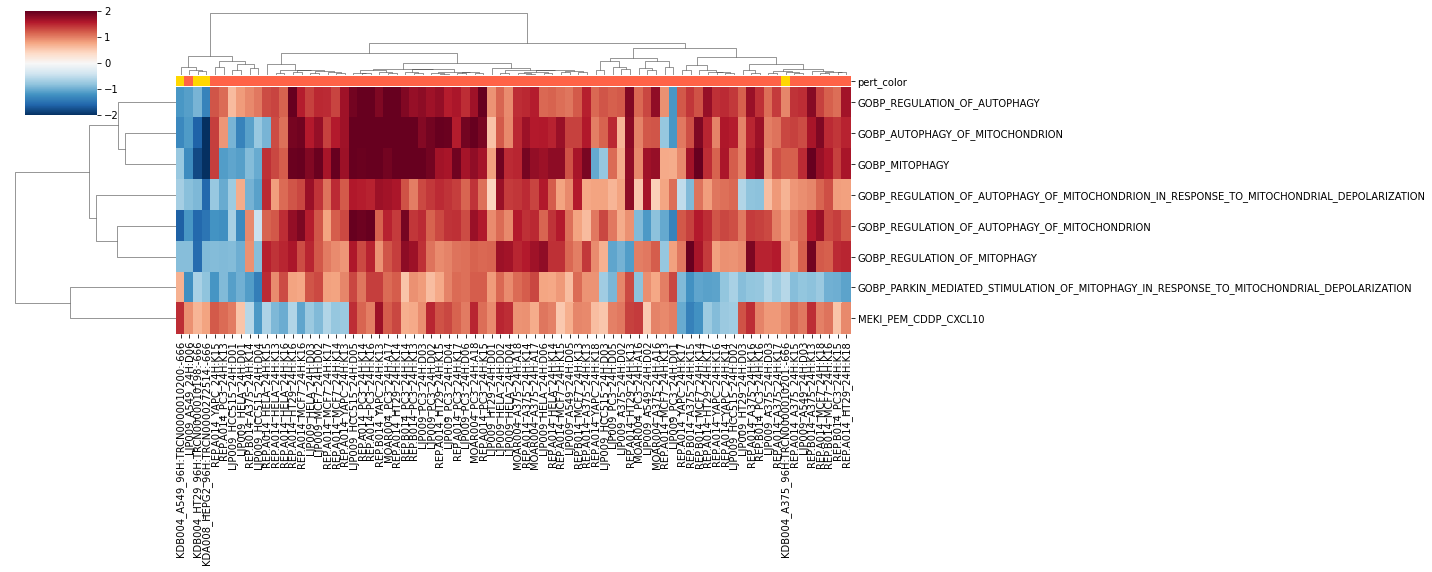

In [97]:
sns.clustermap(mito_nes, method='ward', figsize=(20, 8),
               col_colors=pak4_pert['pert_color'],
               cmap='RdBu_r', vmin=-2, vmax=2)

## 1.2 run on all shRNA perts (tas >= 0.4)

In [55]:
# run prerank
for p in shRNA_all.index:
    p_rename = '__'.join(p.split(':'))
    try:
        gp.prerank(rnk=pd.read_csv(pre_rank_path_direct[p_rename + '.rnk'], header=None, sep='\t'),
                   gene_sets=mitophagy_home + 'MSigDB/mitophagy_curated.gmt',
                   processes=4,
                   permutation_num=100,
                   outdir=mitophagy_home + 'GSEA_sh/' + p,
                   format='pdf', seed=0, min_size=0, max_size=500)
    except KeyError:
        pass

In [56]:
# merge the results
mito_sh_nes = df(index=mitophagy_curated.keys())
mito_sh_fdr = df(index=mitophagy_curated.keys())
for p in os.listdir(mitophagy_home + 'GSEA_sh/'):
    tmp_p = pd.read_csv(mitophagy_home + 'GSEA_sh/' + p + '/gseapy.prerank.gene_sets.report.csv',
                        header=0, index_col=0, sep=',')
    mito_sh_nes[p] = tmp_p['nes']
    mito_sh_fdr[p] = tmp_p['fdr']

In [57]:
mito_sh_nes

,TAK001_A375_96H:TRCN0000280024:-666,ERGK013_VCAP_120H:TRCN0000082417:-666,KDB010_HEPG2_96H:TRCN0000002078:-666,KDB005_A549_96H:TRCN0000013125:-666,KDB002_HEPG2_96H:TRCN0000160787:-666,KDC003_VCAP_120H:TRCN0000060852:-666,KDC001_HEPG2_96H:TRCN0000013626:-666,KDB004_A549_96H:TRCN0000046584:-666,KDA004_PC3_96H:TRCN0000045360:-666,KDC001_VCAP_120H:TRCN0000019099:-666,...,KDA008_A375_96H:TRCN0000021882:-666,KDC001_HEPG2_96H:TRCN0000108007:-666,KDD001_A375_96H:TRCN0000011251:-666,KDB008_A375_96H:TRCN0000038416:-666,KDB005_PC3_96H:TRCN0000004045:-666,KDA002_A375_96H:TRCN0000061801:-666,KDD006_A375_96H:TRCN0000082898:-666,KDD009_PC3_96H:TRCN0000009980:-666,KDA006_MCF7_96H:TRCN0000330395:-666,KDD008_HT29_96H:TRCN0000000588:-666
GOBP_AUTOPHAGY_OF_MITOCHONDRION,-0.750774,-1.058871,0.808745,-0.868271,-1.333783,-1.517023,-1.162784,-1.004371,-0.870157,-0.713821,...,-0.742294,-1.308079,1.717830,0.877385,-1.030870,1.203564,1.013946,-1.402178,-1.219019,-1.215896
GOBP_MITOPHAGY,-1.164326,-1.903834,-0.895612,-1.009620,-1.125923,-1.665937,-1.282631,-1.251876,1.292396,-0.811714,...,-1.221577,-0.816225,2.115632,-1.225491,-0.999532,1.481314,-0.710619,-1.295906,-1.423350,-1.367232
GOBP_PARKIN_MEDIATED_STIMULATION_OF_MITOPHAGY_IN_RESPONSE_TO_MITOCHONDRIAL_DEPOLARIZATION,-0.844094,0.610790,0.556459,1.016537,0.560777,-0.699773,-0.889151,-1.011479,1.009760,1.346485,...,-1.063932,1.035757,0.846250,-1.397685,1.162654,0.884332,-0.590111,-0.880759,-1.083552,-1.223388
GOBP_REGULATION_OF_AUTOPHAGY,1.150669,-0.915680,0.880870,-1.216863,-1.115941,-1.002066,-1.092060,-0.978992,0.728683,0.949790,...,-1.055252,0.862794,1.067091,-1.269918,0.938769,1.113881,-0.897577,-1.242239,0.759236,0.713202
GOBP_REGULATION_OF_AUTOPHAGY_OF_MITOCHONDRION,-1.555658,-1.469734,1.103793,-1.251457,-1.484775,-1.294634,-1.305132,-1.223600,-0.903830,-1.320369,...,1.323234,-0.779073,1.175183,-1.413788,-1.330024,1.357779,1.635379,0.762744,-1.426917,-1.513506
GOBP_REGULATION_OF_AUTOPHAGY_OF_MITOCHONDRION_IN_RESPONSE_TO_MITOCHONDRIAL_DEPOLARIZATION,-0.688342,-0.641730,0.553031,-0.619503,-0.526573,-0.788400,0.571965,-1.072483,-0.917559,0.713760,...,-0.823047,1.012348,1.241484,-1.448160,0.861457,1.210643,0.560456,-1.417469,-0.562616,-1.105402
GOBP_REGULATION_OF_MITOPHAGY,-1.788370,-1.706390,0.442696,-0.993043,-1.136585,-1.622495,-0.803094,-0.993336,1.439512,-1.159799,...,-0.715813,0.896703,1.396328,-1.125254,-1.177708,1.100176,1.292372,-0.830197,-1.560898,-1.478911
MEKI_PEM_CDDP_CXCL10,1.054125,1.367913,0.761931,0.848148,0.488220,1.122386,0.942971,-0.943749,-0.791150,0.756923,...,-1.143371,1.311985,0.774356,-1.128371,0.945009,0.529506,-0.888247,-1.728201,0.670191,-0.763863


In [61]:
mito_sh_nes_clean = mito_sh_nes.replace(np.inf, np.nan).fillna(0)

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


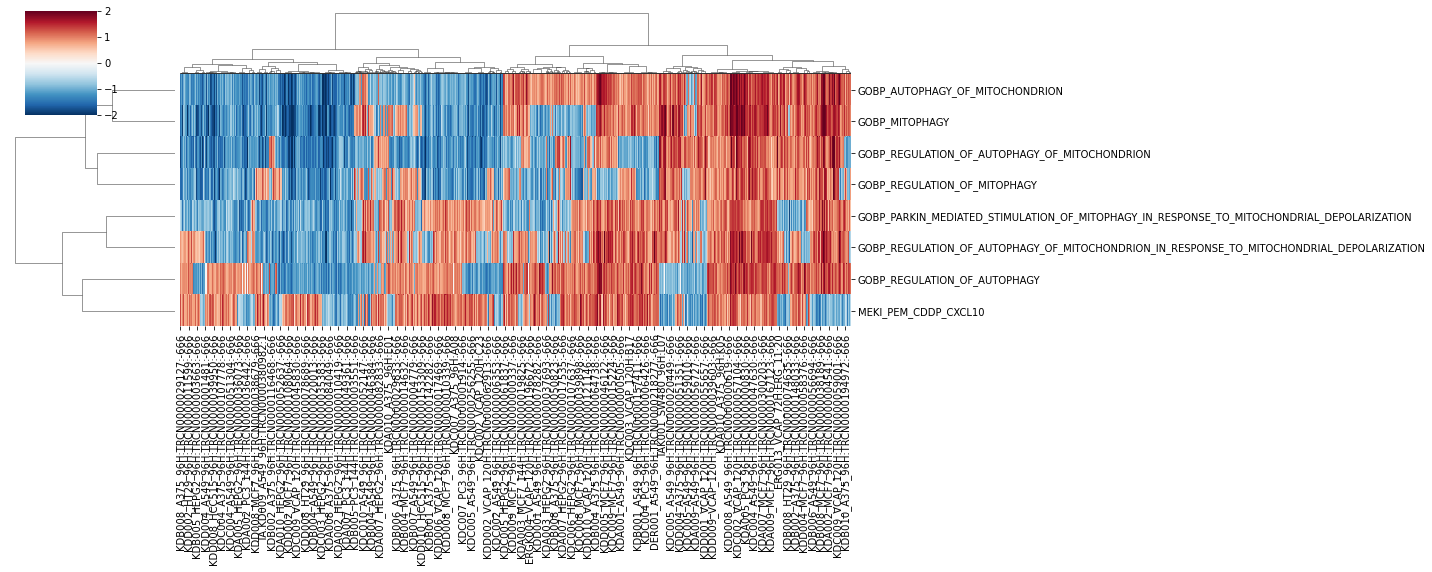

In [98]:
sns.clustermap(mito_sh_nes_clean, method='ward', figsize=(20, 8),
               cmap='RdBu_r', vmin=-2, vmax=2)

In [91]:
tmp_sh_mito = df(mito_sh_nes_clean.T.sort_values(by='GOBP_MITOPHAGY', ascending=False))

In [92]:
tmp_sh_mito['cmap_name'] = sig_info['cmap_name']

In [93]:
tmp_sh_mito[tmp_sh_mito['cmap_name'] == 'PAK4']

,GOBP_AUTOPHAGY_OF_MITOCHONDRION,GOBP_MITOPHAGY,GOBP_PARKIN_MEDIATED_STIMULATION_OF_MITOPHAGY_IN_RESPONSE_TO_MITOCHONDRIAL_DEPOLARIZATION,GOBP_REGULATION_OF_AUTOPHAGY,GOBP_REGULATION_OF_AUTOPHAGY_OF_MITOCHONDRION,GOBP_REGULATION_OF_AUTOPHAGY_OF_MITOCHONDRION_IN_RESPONSE_TO_MITOCHONDRIAL_DEPOLARIZATION,GOBP_REGULATION_OF_MITOPHAGY,MEKI_PEM_CDDP_CXCL10,cmap_name
KDB004_A375_96H:TRCN0000010201:-666,1.333867,1.200074,-0.577362,0.975069,0.846576,0.690227,0.949857,0.962287,PAK4
KDB004_A549_96H:TRCN0000010200:-666,-1.296500,-0.756833,0.713273,-1.164470,-1.633637,-0.685436,-0.855701,1.482570,PAK4
KDB004_HT29_96H:TRCN0000010198:-666,-1.621458,-1.812184,-0.653006,-0.926444,-1.568601,-0.899876,-1.539061,0.680115,PAK4
KDA008_HEPG2_96H:TRCN0000272514:-666,-2.035554,-2.071740,-0.807801,-1.333827,-1.454981,-1.568425,-0.877550,0.807543,PAK4


## 1.3 run on all the compounds (tas >= .4)

In [100]:
# run prerank
for p in cp_all.index:
    p_rename = '__'.join(p.split(':'))
    try:
        gp.prerank(rnk=pd.read_csv(pre_rank_path_direct[p_rename + '.rnk'], header=None, sep='\t'),
                   gene_sets=mitophagy_home + 'MSigDB/mitophagy_curated.gmt',
                   processes=8,
                   permutation_num=100,
                   outdir=mitophagy_home + 'GSEA_cp/' + p,
                   no_plot=True, seed=0, min_size=0, max_size=500)
    except KeyError:
        pass

In [101]:
# merge the results
mito_cp_nes = df(index=mitophagy_curated.keys())
mito_cp_fdr = df(index=mitophagy_curated.keys())
for p in os.listdir(mitophagy_home + 'GSEA_cp/'):
    tmp_p = pd.read_csv(mitophagy_home + 'GSEA_cp/' + p + '/gseapy.prerank.gene_sets.report.csv',
                        header=0, index_col=0, sep=',')
    mito_cp_nes[p] = tmp_p['nes']
    mito_cp_fdr[p] = tmp_p['fdr']

In [102]:
mito_cp_nes_clean = mito_cp_nes.replace(np.inf, np.nan).fillna(0)

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


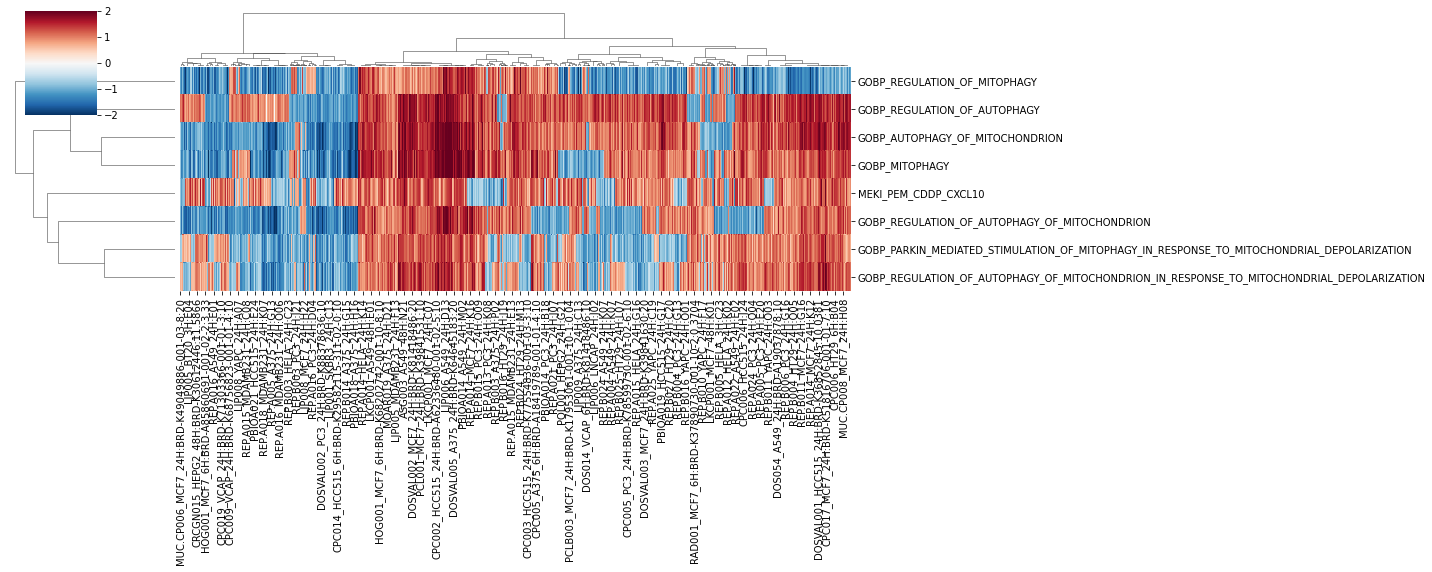

In [103]:
sns.clustermap(mito_cp_nes_clean, method='ward', figsize=(20, 8),
               cmap='RdBu_r', vmin=-2, vmax=2)

In [104]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [108]:
distanceMatrix = pdist(mito_cp_nes_clean.T)

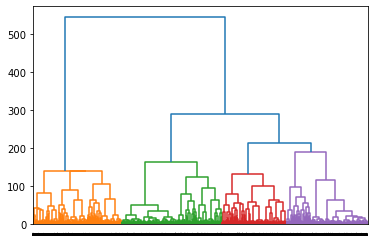

In [116]:
dend = dendrogram(linkage(distanceMatrix, method='ward'), 
                  color_threshold=200,
                  no_labels=True,
                  leaf_font_size=1)

In [120]:
dend.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])

In [161]:
cluster_size = {}
for c in set(dend['color_list']):
    print(c)
    print(len([i for i in dend['color_list'] if i == c]))
    cluster_size[c] = len([i for i in dend['color_list'] if i == c]) + 1

C0
3
C3
7955
C1
10956
C2
12365
C4
10043


In [162]:
cluster_size

{'C0': 4, 'C3': 7956, 'C1': 10957, 'C2': 12366, 'C4': 10044}

In [168]:
# assign cluster
mito_cp_cluster = df(index=mito_cp_nes_clean.columns, columns=['cluster'])
for i in range(cluster_size['C1']):
    mito_cp_cluster.at[mito_cp_cluster.index[dend['leaves'][i]], 'cluster'] = 'C1'
for i in range(cluster_size['C2']):
    mito_cp_cluster.at[mito_cp_cluster.index[dend['leaves'][cluster_size['C1'] + i]], 'cluster'] = 'C2'
for i in range(cluster_size['C3']):
    mito_cp_cluster.at[mito_cp_cluster.index[dend['leaves'][cluster_size['C1'] + cluster_size['C2'] + i]], 'cluster'] = 'C3'
for i in range(cluster_size['C4']):
    mito_cp_cluster.at[mito_cp_cluster.index[dend['leaves'][cluster_size['C1'] + cluster_size['C2'] + cluster_size['C3'] + i]], 'cluster'] = 'C4'

In [170]:
mito_cp_cluster['cmap_name'] = sig_info['cmap_name']

In [174]:
mito_cp_cluster[mito_cp_cluster['cmap_name'] == 'PF-03758309']['cluster'].value_counts()

C2    59
C3     6
C4     5
C1     4
Name: cluster, dtype: int64

In [175]:
# map moa
mito_cp_cluster['moa'] = 'Not available'
mito_cp_cluster['target'] = 'Not available'
for p in mito_cp_cluster.index:
    tmp_p = mito_cp_cluster.loc[p, 'cmap_name']
    if tmp_p in compound_info.index:
        mito_cp_cluster.at[p, 'moa'] = compound_info.loc[tmp_p, 'moa']
        mito_cp_cluster.at[p, 'target'] = compound_info.loc[tmp_p, 'target']
mito_cp_cluster = mito_cp_cluster.fillna('Not available')

In [176]:
mito_cp_cluster

,cluster,cmap_name,moa,target
MOAR005_A375_24H:H04,C2,BRD-K60167861,Not available,Not available
REP.B008_HELA_24H:O04,C4,MG-132,Proteasome inhibitor,PSMB1
CPC006_MCF7_24H:M15,C4,SU-11652,Tyrosine kinase inhibitor,KDR
REP.A005_HELA_24H:C21,C3,bortezomib,Proteasome inhibitor,PSMB1
REP.B021_MCF7_24H:I05,C2,NMS-1286937,PLK inhibitor,PLK1
...,...,...,...,...
REP.A018_MCF7_24H:C01,C1,prednisone,Glucocorticoid receptor agonist,NR3C1
REP.B001_YAPC_24H:G18,C3,bortezomib,Proteasome inhibitor,PSMB1
REP.A021_HELA_24H:I02,C1,NMS-1286937,PLK inhibitor,PLK1
PBIOA019_PC3_24H:I01,C2,BRD-K46556387,Not available,Not available


In [177]:
mito_cp_cluster.to_csv(mitophagy_home + 'cluster_cp/cluster_by_mitophagy_nes.csv', sep=',')

In [178]:
mito_cp_nes.to_csv(mitophagy_home + 'cluster_cp/nes_matrix_mitophagy.csv', sep=',')
mito_cp_fdr.to_csv(mitophagy_home + 'cluster_cp/fdr_matrix_mitophagy.csv', sep=',')

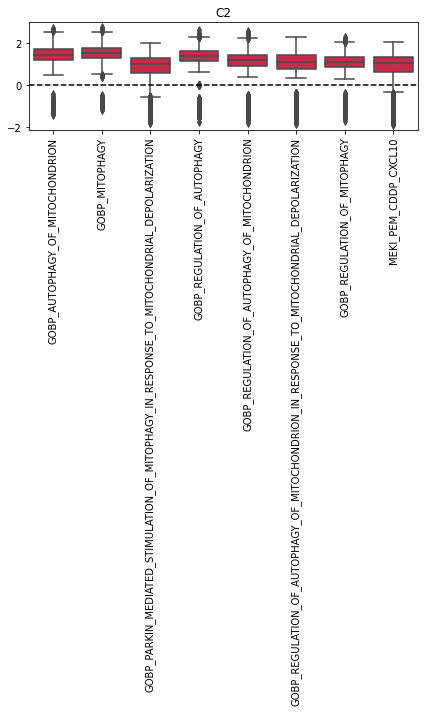

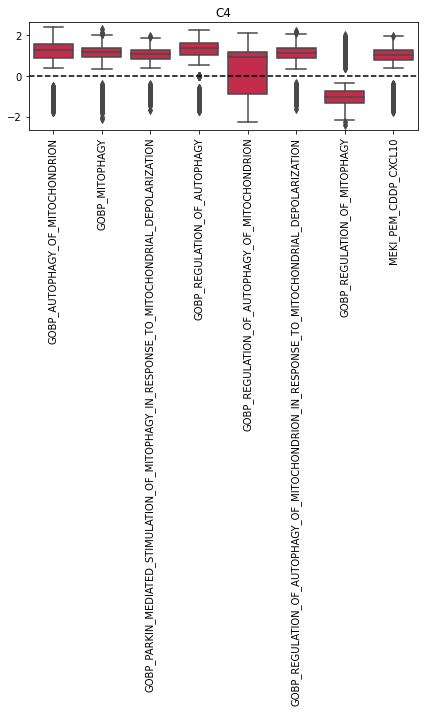

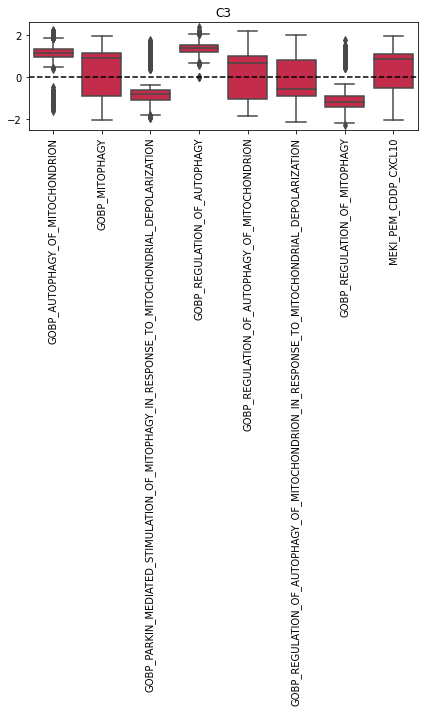

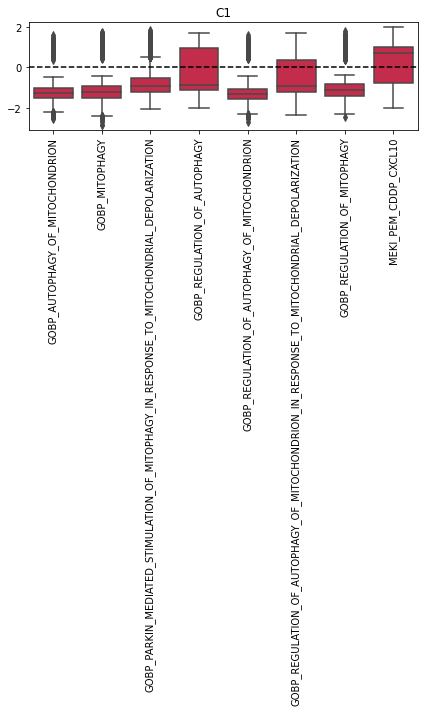

In [213]:
# mitophagy by cluster
for c in mito_cp_cluster['cluster'].unique():
    tmp_c = mito_cp_cluster[mito_cp_cluster['cluster'] == c].index
    tmp_m = df(mito_cp_nes_clean[tmp_c]).T
    plt.figure(figsize=(6, 10))
    sns.boxplot(data=tmp_m, color='crimson')
    plt.xticks(rotation=90)
    plt.axhline(y=0., c='k', ls='--')
    plt.title(c)
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(mitophagy_home + 'cluster_cp/average_mitophagy_' + c + '.png', transparent=True, dpi=300)
    plt.show()

In [236]:
# moa enrichment in each cluster
mito_moa_count = df(index=mito_cp_cluster['moa'].unique(),
                    columns=mito_cp_cluster['cluster'].unique())
for c in mito_cp_cluster['cluster'].unique():
    tmp_c = mito_cp_cluster[mito_cp_cluster['cluster'] == c]
    mito_moa_count[c] = tmp_c['moa'].value_counts()
mito_moa_count = mito_moa_count.fillna(0)
mito_moa_count_selected = df(mito_moa_count.sum(axis=1))
mito_moa_count_selected = mito_moa_count_selected[mito_moa_count_selected[0] > 20]
# only select moa with 20 or more experiments
mito_moa_count_selected = mito_moa_count_selected.drop(index='Not available')
mito_moa_count_selected.shape

(120, 1)

In [237]:
mito_moa_freq = mito_moa_count[mito_moa_count.index.isin(mito_moa_count_selected.index)]
for c in mito_moa_freq.columns:
    mito_moa_freq[c] = mito_moa_freq[c] / mito_moa_count_selected[0]

<ipython-input-237-53a8e2a0e8f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mito_moa_freq[c] = mito_moa_freq[c] / mito_moa_count_selected[0]


In [238]:
mito_moa_freq

,C2,C4,C3,C1
Proteasome inhibitor,0.033371,0.331243,0.412430,0.222956
Tyrosine kinase inhibitor,0.243590,0.153846,0.115385,0.487179
PLK inhibitor,0.501736,0.190972,0.067708,0.239583
MTOR inhibitor,0.437447,0.356596,0.063830,0.142128
Serine/threonine kinase inhibitor,0.065217,0.130435,0.217391,0.586957
...,...,...,...,...
Adenosine deaminase inhibitor,0.285714,0.142857,0.071429,0.500000
Endothelin receptor antagonist,0.217391,0.086957,0.260870,0.434783
Dopamine receptor agonist,0.136364,0.363636,0.000000,0.500000
Mitochondrial complex I inhibitor,0.343750,0.312500,0.250000,0.093750


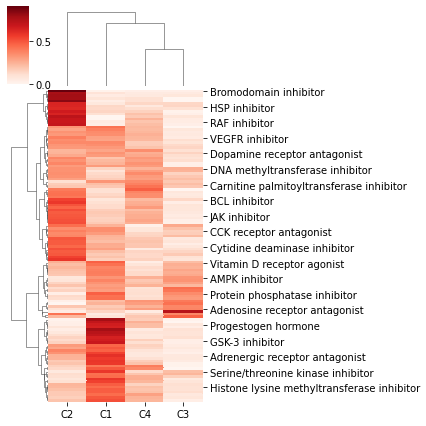

In [253]:
sns.clustermap(mito_moa_freq,
               figsize=(6, 6),
               method='ward', cmap='Reds')

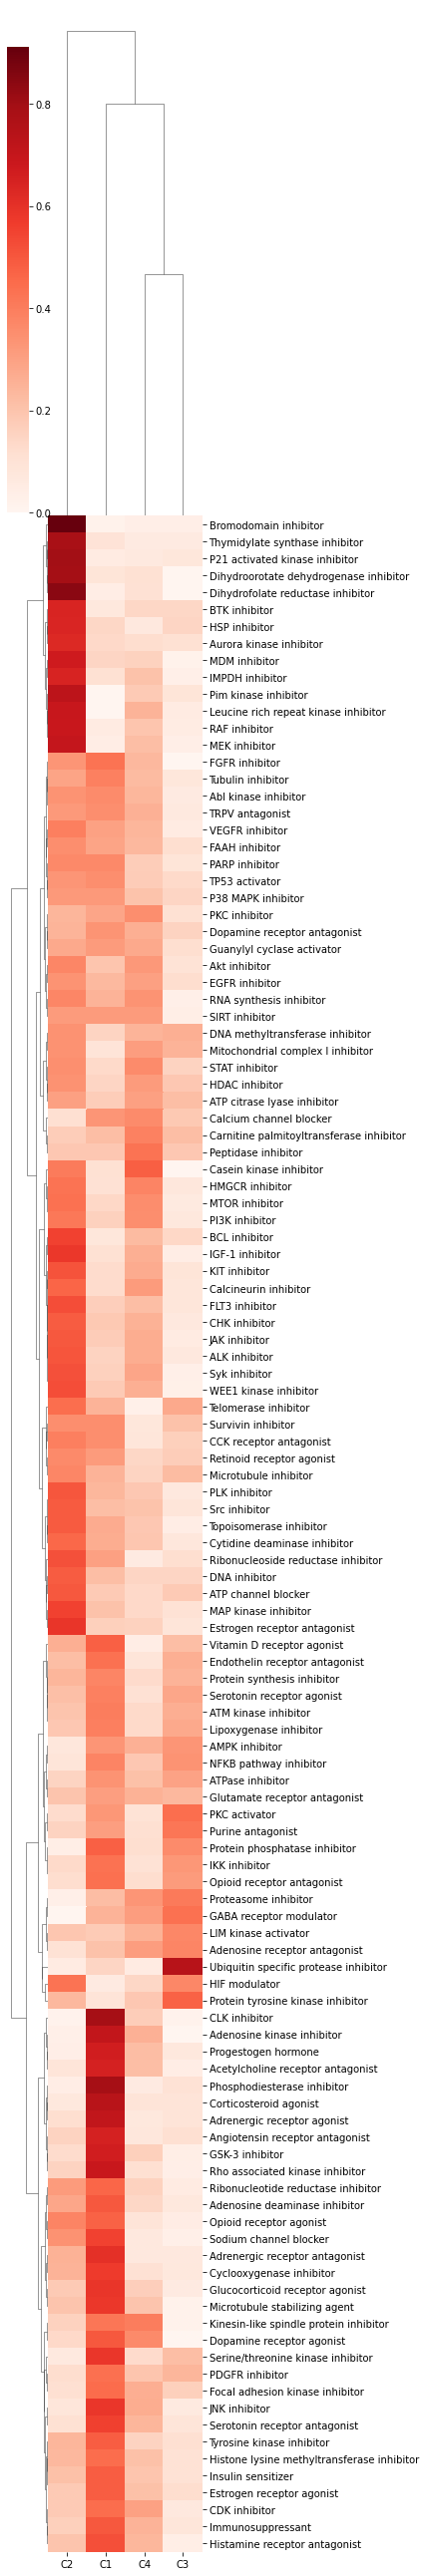

In [252]:
sns.clustermap(mito_moa_freq,
               figsize=(6, 36),
               method='ward', cmap='Reds')
fig = plt.gcf()
fig.savefig(mitophagy_home + 'cluster_cp/mitophagy_by_moa_cluster.png', dpi=300)
fig.savefig(mitophagy_home + 'cluster_cp/mitophagy_by_moa_cluster.pdf')

In [267]:
compound_info[compound_info['moa'] == 'Bromodomain inhibitor']

,pert_id,target,moa,canonical_smiles,inchi_key,compound_aliases
cmap_name,,,,,,
I-BET-762,BRD-K08109215,BRD4,Bromodomain inhibitor,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK-525762A


# 2. CXCL10 induction and mitophagy

In [268]:
cxcl10_expr = df(pd.read_csv(poseidon_home + 'ICD/ICD_selected_expr_matrix.csv',
                          header=0, index_col=0, sep=',')['CXCL10'])

In [269]:
cxcl10_expr

,CXCL10
ERBB2001_VMCUB1_24H:BRD-K42805893:10,-0.607125
ERBB2001_VMCUB1_24H:BRD-K66175015:10,1.171627
ERBB2002_5637_24H:BRD-K66175015:10,0.370372
ERBB2002_J82_24H:BRD-K42805893:10,0.889911
ERBB2002_J82_24H:BRD-K66175015:10,0.775241
...,...
CPC006_SNGM_6H:BRD-K92317137-001-04-0:10,-0.454500
ERBB2001_MFE319_24H:BRD-K42805893:10,0.170996
ERBB2002_AN3CA_24H:BRD-K42805893:10,-0.331987
ERBB2002_AN3CA_24H:BRD-K66175015:10,-0.369940


In [271]:
mito_cp_cluster['CXCL10'] = cxcl10_expr['CXCL10']

## 2.1 CXCL10 induction by each mito-cluster

<AxesSubplot:xlabel='cluster', ylabel='CXCL10'>

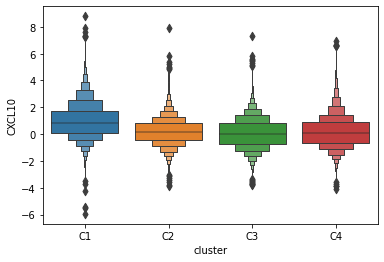

In [274]:
# boxplot on cxcl10 by each cluster
sns.boxenplot(x='cluster', y='CXCL10',
              order=['C1', 'C2', 'C3', 'C4'],
              data=mito_cp_cluster)

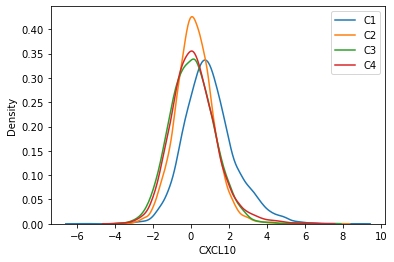

In [294]:
for c in ['C1', 'C2', 'C3', 'C4']:
    sns.kdeplot(mito_cp_cluster[mito_cp_cluster['cluster'] == c]['CXCL10'], label=c)
plt.legend()
plt.show()

## 2.2 shift ability by each cluster

In [277]:
# all shift ability
tmp_shift = []
for c in os.listdir(poseidon_home + 'shift_ability/'):
    tmp_shift.append(pd.read_csv(poseidon_home + 'shift_ability/' + c,
                                 index_col=0, header=0, sep=','))
shift_ability = pd.concat(tmp_shift, axis=0)

In [278]:
shift_ability

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability
CPC006_EFO27_6H:BRD-K92317137-001-04-0:10,-0.382604,0.419364,BRD-K92317137,10.00,10 uM,0.801968
CPC006_EFO27_6H:BRD-K06792661-001-01-9:10,-0.383801,0.336175,narciclasine,10.00,10 uM,0.719976
CPC006_RMUGS_6H:H17,-0.323721,0.381982,BI-2536,10.00,10 uM,0.705704
CPC006_EFO27_6H:BRD-K15025317-001-05-2:10,-0.255395,0.428858,BAY-11-7082,10.00,10 uM,0.684253
CPC006_EFO27_6H:BRD-K64890080-001-03-9:10,-0.367471,0.316249,BI-2536,10.00,10 uM,0.683721
...,...,...,...,...,...,...
REP.B028_HELA_24H:P14,0.344649,-0.499666,gestrinone,0.74,0.74 uM,-0.844315
REP.B013_HELA_24H:A21,0.380037,-0.470181,zardaverine,0.25,0.25 uM,-0.850218
REP.A017_HELA_24H:B19,0.384480,-0.474822,palomid-529,10.00,10 uM,-0.859301
REP.A006_HELA_24H:B07,0.410627,-0.448787,estradiol,10.00,10 uM,-0.859414


In [279]:
mito_cp_cluster['shift_ability'] = shift_ability['shift_ability']

<AxesSubplot:xlabel='cluster', ylabel='shift_ability'>

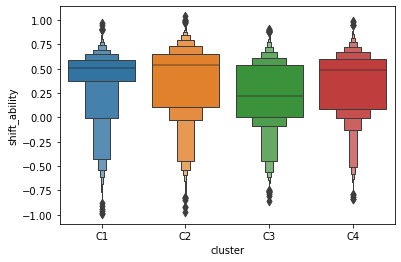

In [283]:
# boxplot on shift ability by each cluster
sns.boxenplot(x='cluster', y='shift_ability',
              order=['C1', 'C2', 'C3', 'C4'],
              data=mito_cp_cluster)

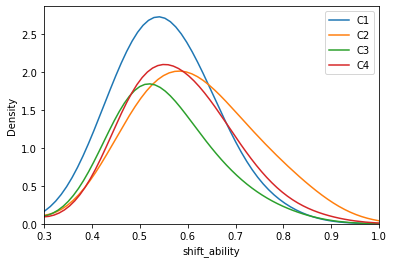

In [292]:
for c in ['C1', 'C2', 'C3', 'C4']:
    sns.kdeplot(mito_cp_cluster[mito_cp_cluster['cluster'] == c]['shift_ability'], label=c)
plt.legend()
plt.xlim(0.3, 1.)
plt.show()

## 2.3 correlation between shift ability, cxcl10 and mitophagy

In [297]:
mito_cp_cluster['go_mitophagy'] = mito_cp_nes_clean.T['GOBP_MITOPHAGY']
mito_cp_cluster['go_mitophagy_regulation'] = mito_cp_nes_clean.T['GOBP_REGULATION_OF_MITOPHAGY']

In [298]:
mito_cp_cluster

,cluster,cmap_name,moa,target,CXCL10,shift_ability,go_mitophagy,go_mitophagy_regulation
MOAR005_A375_24H:H04,C2,BRD-K60167861,Not available,Not available,0.175555,0.823724,1.911588,1.492232
REP.B008_HELA_24H:O04,C4,MG-132,Proteasome inhibitor,PSMB1,-0.884700,0.112220,1.187518,-1.102052
CPC006_MCF7_24H:M15,C4,SU-11652,Tyrosine kinase inhibitor,KDR,1.433512,0.445196,1.325755,-1.266789
REP.A005_HELA_24H:C21,C3,bortezomib,Proteasome inhibitor,PSMB1,0.882497,0.447139,-1.156816,-1.211907
REP.B021_MCF7_24H:I05,C2,NMS-1286937,PLK inhibitor,PLK1,-1.071100,-0.516357,1.821862,1.349258
...,...,...,...,...,...,...,...,...
REP.A018_MCF7_24H:C01,C1,prednisone,Glucocorticoid receptor agonist,NR3C1,0.777331,0.506108,-0.668560,-0.685502
REP.B001_YAPC_24H:G18,C3,bortezomib,Proteasome inhibitor,PSMB1,-1.015550,-0.056079,0.824082,-1.736942
REP.A021_HELA_24H:I02,C1,NMS-1286937,PLK inhibitor,PLK1,1.514732,-0.615298,-1.454228,-1.067313
PBIOA019_PC3_24H:I01,C2,BRD-K46556387,Not available,Not available,0.017917,0.502361,1.483158,0.895675


In [433]:
mito_cp_cluster['pert_time'] = sig_info['pert_time']
mito_cp_cluster['pert_dose'] = sig_info['pert_dose']

In [431]:
mito_cp_cluster['pert_time'].unique()

array([24.,  6.,  3., 48.,  2., 72.])

<AxesSubplot:xlabel='shift_ability', ylabel='CXCL10'>

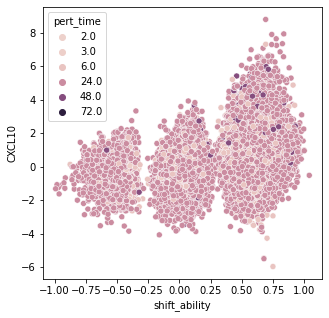

In [432]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='shift_ability', y='CXCL10', hue='pert_time', data=mito_cp_cluster)

<AxesSubplot:xlabel='shift_ability', ylabel='CXCL10'>

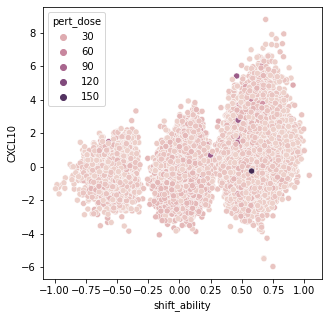

In [434]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='shift_ability', y='CXCL10', hue='pert_dose', data=mito_cp_cluster)

<AxesSubplot:xlabel='go_mitophagy', ylabel='CXCL10'>

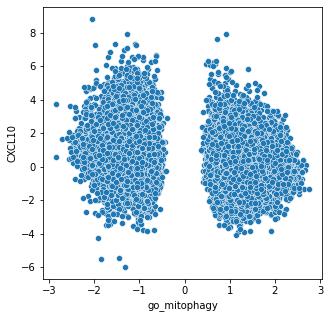

In [398]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='go_mitophagy', y='CXCL10', data=mito_cp_cluster)

In [397]:
mito_cp_cluster.corr(method='pearson')

,CXCL10,shift_ability,go_mitophagy,go_mitophagy_regulation
CXCL10,1.000000,0.371227,-0.302274,-0.020943
shift_ability,0.371227,1.000000,-0.075111,0.090525
go_mitophagy,-0.302274,-0.075111,1.000000,0.484974
go_mitophagy_regulation,-0.020943,0.090525,0.484974,1.000000


C1
                           CXCL10  shift_ability  go_mitophagy  \
CXCL10                   1.000000       0.382164     -0.180515   
shift_ability            0.382164       1.000000     -0.232871   
go_mitophagy            -0.180515      -0.232871      1.000000   
go_mitophagy_regulation -0.079326      -0.092706      0.415865   

                         go_mitophagy_regulation  
CXCL10                                 -0.079326  
shift_ability                          -0.092706  
go_mitophagy                            0.415865  
go_mitophagy_regulation                 1.000000  


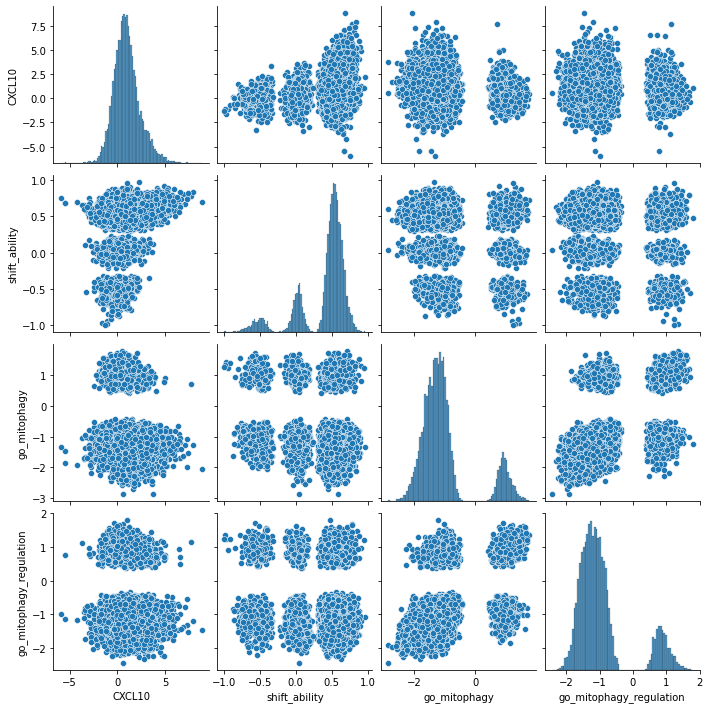

C2
                           CXCL10  shift_ability  go_mitophagy  \
CXCL10                   1.000000       0.362102     -0.112801   
shift_ability            0.362102       1.000000      0.012608   
go_mitophagy            -0.112801       0.012608      1.000000   
go_mitophagy_regulation  0.038766       0.028189      0.489766   

                         go_mitophagy_regulation  
CXCL10                                  0.038766  
shift_ability                           0.028189  
go_mitophagy                            0.489766  
go_mitophagy_regulation                 1.000000  


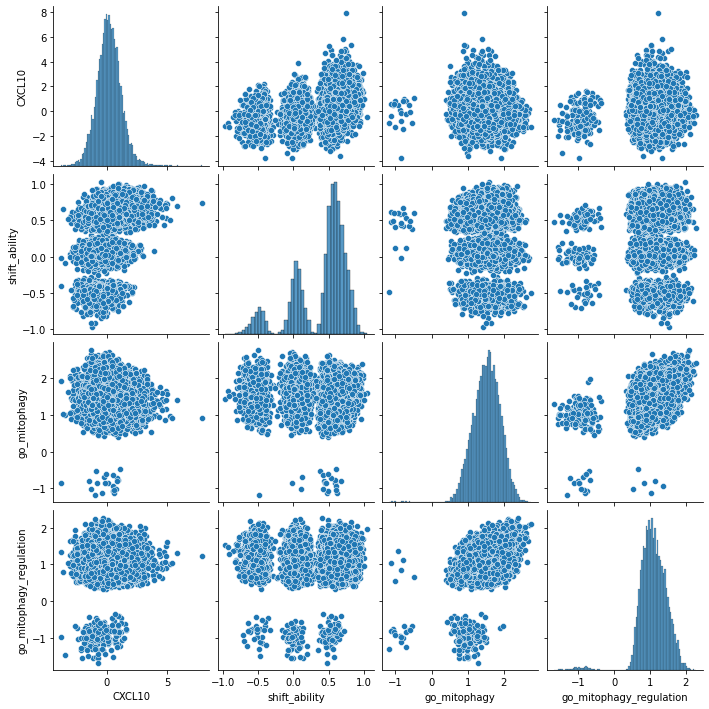

C3
                           CXCL10  shift_ability  go_mitophagy  \
CXCL10                   1.000000       0.358565     -0.100604   
shift_ability            0.358565       1.000000     -0.150593   
go_mitophagy            -0.100604      -0.150593      1.000000   
go_mitophagy_regulation  0.158275       0.149757     -0.129591   

                         go_mitophagy_regulation  
CXCL10                                  0.158275  
shift_ability                           0.149757  
go_mitophagy                           -0.129591  
go_mitophagy_regulation                 1.000000  


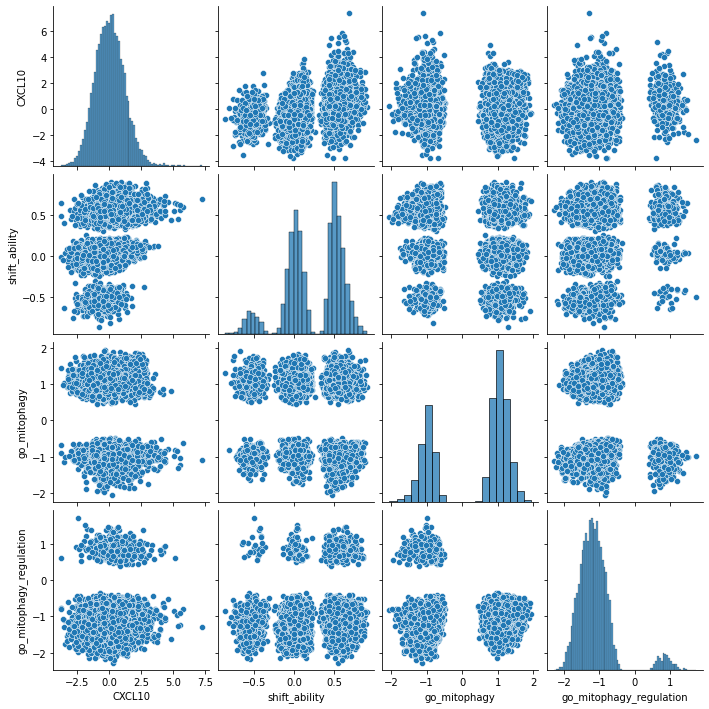

C4
                           CXCL10  shift_ability  go_mitophagy  \
CXCL10                   1.000000       0.392063     -0.314375   
shift_ability            0.392063       1.000000     -0.122890   
go_mitophagy            -0.314375      -0.122890      1.000000   
go_mitophagy_regulation  0.299402       0.124604     -0.226726   

                         go_mitophagy_regulation  
CXCL10                                  0.299402  
shift_ability                           0.124604  
go_mitophagy                           -0.226726  
go_mitophagy_regulation                 1.000000  


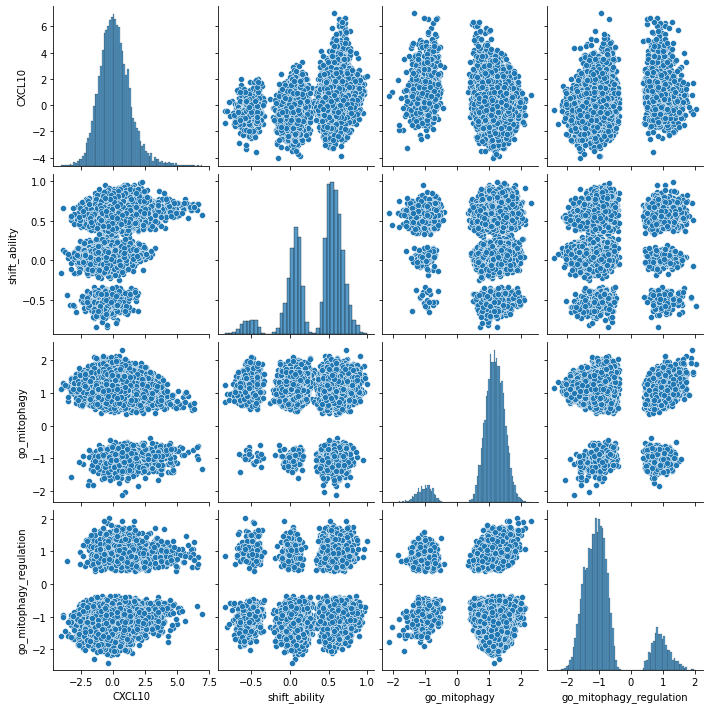

In [301]:
for c in ['C1', 'C2', 'C3', 'C4']:
    tmp_c = mito_cp_cluster[mito_cp_cluster['cluster'] == c]
    print(c)
    print(tmp_c.corr())
    sns.pairplot(tmp_c)
    plt.show()

## 2.4 case correlation

In [303]:
pak4_case = mito_cp_cluster[mito_cp_cluster['moa'] == 'P21 activated kinase inhibitor']

In [322]:
pak4_case.corr(method='pearson')

,CXCL10,shift_ability,go_mitophagy,go_mitophagy_regulation
CXCL10,1.000000,0.206149,-0.393988,-0.421951
shift_ability,0.206149,1.000000,0.106022,-0.042315
go_mitophagy,-0.393988,0.106022,1.000000,0.626827
go_mitophagy_regulation,-0.421951,-0.042315,0.626827,1.000000


<AxesSubplot:xlabel='CXCL10', ylabel='shift_ability'>

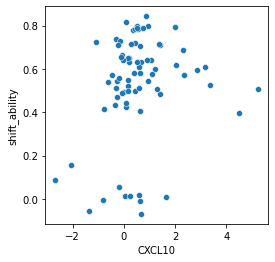

In [318]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='CXCL10', y='shift_ability',
                data=pak4_case)

<AxesSubplot:xlabel='CXCL10', ylabel='go_mitophagy'>

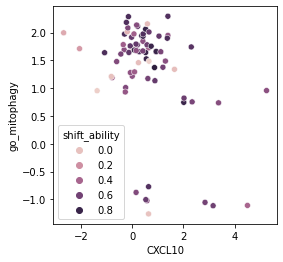

In [311]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='CXCL10', y='go_mitophagy',
                hue='shift_ability',
                data=pak4_case)

<AxesSubplot:xlabel='CXCL10', ylabel='go_mitophagy_regulation'>

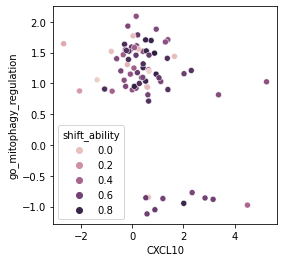

In [313]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='CXCL10', y='go_mitophagy_regulation',
                hue='shift_ability',
                data=pak4_case)

In [316]:
pak4_case

,cluster,cmap_name,moa,target,CXCL10,shift_ability,go_mitophagy,go_mitophagy_regulation
REP.A014_HT29_24H:K17,C2,PF-03758309,P21 activated kinase inhibitor,PAK4,-0.605034,0.540990,1.478801,1.400060
REP.A014_PC3_24H:K17,C2,PF-03758309,P21 activated kinase inhibitor,PAK4,0.371830,0.778947,1.941842,1.093633
REP.B014_PC3_24H:K14,C2,PF-03758309,P21 activated kinase inhibitor,PAK4,0.214100,0.650289,2.111810,1.786803
LJP009_HELA_24H:D03,C2,PF-03758309,P21 activated kinase inhibitor,PAK4,0.419982,0.499793,1.843824,1.520059
MOAR004_PC3_24H:A17,C2,PF-03758309,P21 activated kinase inhibitor,PAK4,0.426025,0.782614,1.934331,1.255391
...,...,...,...,...,...,...,...,...
REP.A014_A375_24H:K17,C2,PF-03758309,P21 activated kinase inhibitor,PAK4,0.091350,0.441845,1.293238,1.579611
REP.B014_A375_24H:K15,C2,PF-03758309,P21 activated kinase inhibitor,PAK4,0.157000,0.499144,1.676575,2.089659
REP.A014_PC3_24H:K16,C2,PF-03758309,P21 activated kinase inhibitor,PAK4,-0.225816,0.711207,2.183763,1.533441
LJP009_HELA_24H:D04,C2,PF-03758309,P21 activated kinase inhibitor,PAK4,1.297165,0.508504,1.487990,1.671983


In [305]:
mek_case = mito_cp_cluster[mito_cp_cluster['moa'] == 'MEK inhibitor']

In [323]:
mek_case.corr(method='pearson')

,CXCL10,shift_ability,go_mitophagy,go_mitophagy_regulation
CXCL10,1.000000,0.237269,-0.122293,-0.059471
shift_ability,0.237269,1.000000,0.228049,0.083344
go_mitophagy,-0.122293,0.228049,1.000000,0.564167
go_mitophagy_regulation,-0.059471,0.083344,0.564167,1.000000


In [402]:
mek_case.corr(method='spearman')

,CXCL10,shift_ability,go_mitophagy,go_mitophagy_regulation
CXCL10,1.000000,0.237872,-0.137867,-0.065381
shift_ability,0.237872,1.000000,0.269772,0.101532
go_mitophagy,-0.137867,0.269772,1.000000,0.592299
go_mitophagy_regulation,-0.065381,0.101532,0.592299,1.000000


<AxesSubplot:xlabel='CXCL10', ylabel='shift_ability'>

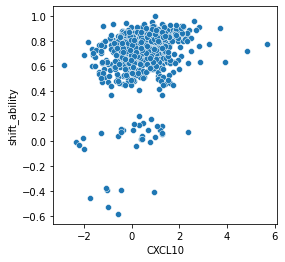

In [319]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='CXCL10', y='shift_ability',
                data=mek_case)

<AxesSubplot:xlabel='CXCL10', ylabel='go_mitophagy'>

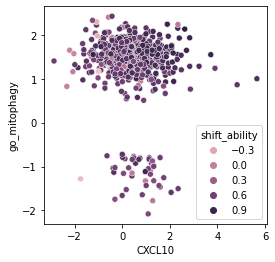

In [314]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='CXCL10', y='go_mitophagy',
                hue='shift_ability',
                data=mek_case)

<AxesSubplot:xlabel='CXCL10', ylabel='go_mitophagy_regulation'>

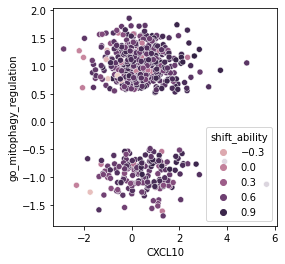

In [315]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='CXCL10', y='go_mitophagy_regulation',
                hue='shift_ability',
                data=mek_case)

## 2.5 CXCL10 vs. shift ability by MOA in each cluster

In [407]:
cxcl10_shift_corr = df(columns=['pearsonr', 'pearsonp', 'ave_CXCL10', 'ave_shift_ability',
                                'moa', 'cluster', '#experiment', '#drug'])
for c in mito_cp_cluster['cluster'].unique():
    tmp_c = mito_cp_cluster[mito_cp_cluster['cluster'] == c]
    # traverse the MOAs
    for m in tmp_c['moa'].unique():
        if m == 'Not available':
            continue
        tmp_c_m = tmp_c[tmp_c['moa'] == m].dropna(axis=0, how='any')
        if tmp_c_m.shape[0] < 10:
            continue
        tmp_index = c + '_' + m
        cxcl10_shift_corr.at[tmp_index, 'pearsonr'], cxcl10_shift_corr.at[tmp_index, 'pearsonp'] = stats.pearsonr(tmp_c_m['shift_ability'], tmp_c_m['CXCL10'])
        cxcl10_shift_corr.at[tmp_index, 'moa'] = m
        cxcl10_shift_corr.at[tmp_index, 'cluster'] = c
        cxcl10_shift_corr.at[tmp_index, '#experiment'] = tmp_c_m.shape[0]
        cxcl10_shift_corr.at[tmp_index, '#drug'] = tmp_c_m['cmap_name'].unique().shape[0]
        cxcl10_shift_corr.at[tmp_index, 'ave_CXCL10'] = tmp_c_m['CXCL10'].mean()
        cxcl10_shift_corr.at[tmp_index, 'ave_shift_ability'] = tmp_c_m['shift_ability'].mean()

In [408]:
cxcl10_shift_corr

,pearsonr,pearsonp,ave_CXCL10,ave_shift_ability,moa,cluster,#experiment,#drug
C2_PLK inhibitor,0.439033,4.78324e-15,-0.561806,0.0889068,PLK inhibitor,C2,289,9
C2_JAK inhibitor,0.342579,1.699e-06,0.549701,0.3859,JAK inhibitor,C2,186,12
C2_Topoisomerase inhibitor,0.283811,1.12311e-15,0.877741,0.664852,Topoisomerase inhibitor,C2,767,16
C2_MTOR inhibitor,0.216427,7.28463e-07,-0.0762205,0.450366,MTOR inhibitor,C2,514,19
C2_HDAC inhibitor,0.194738,1.0496e-07,0.11596,0.551296,HDAC inhibitor,C2,734,23
...,...,...,...,...,...,...,...,...
C1_AMPK inhibitor,-0.0516606,0.866893,1.54772,0.557769,AMPK inhibitor,C1,13,1
C1_Dopamine receptor agonist,-0.397589,0.22593,0.463659,0.485459,Dopamine receptor agonist,C1,11,9
C1_Opioid receptor antagonist,0.186865,0.457806,1.36509,0.468745,Opioid receptor antagonist,C1,18,7
C1_Immunosuppressant,-0.110312,0.732886,1.20888,0.475909,Immunosuppressant,C1,12,2


In [384]:
cxcl10_shift_corr['-log10P'] = -np.log10(cxcl10_shift_corr['pearsonp'].astype(float))

Text(0.5, 1.0, 'CXCL10 vs. shift ability')

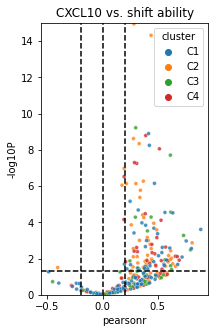

In [385]:
plt.figure(figsize=(3, 5))
sns.scatterplot(x='pearsonr', y='-log10P',
                s=15, alpha=0.8,
                hue='cluster', hue_order=['C1', 'C2', 'C3', 'C4'],
                data=cxcl10_shift_corr)
plt.ylim(0, 15)
plt.axvline(x=0., c='k', ls='--')
plt.axvline(x=0.2, c='k', ls='--')
plt.axvline(x=-0.2, c='k', ls='--')
plt.axhline(y=-np.log10(0.05), c='k', ls='--')
plt.title('CXCL10 vs. shift ability')

In [386]:
# significant CXCL10 vs. shift ability in each cluster
cxcl10_shift_corr_top = cxcl10_shift_corr[cxcl10_shift_corr['pearsonr'] >= 0.2]
cxcl10_shift_corr_top = cxcl10_shift_corr_top[cxcl10_shift_corr_top['pearsonp'] <= 0.05]

In [387]:
cxcl10_shift_corr_top['cluster'].value_counts()

C2    43
C1    38
C4    26
C3    18
Name: cluster, dtype: int64

In [388]:
# original
cxcl10_shift_corr['cluster'].value_counts()

C1    96
C2    88
C4    64
C3    51
Name: cluster, dtype: int64

In [394]:
cxcl10_shift_corr_top[cxcl10_shift_corr_top['cluster'] == 'C1'].sort_values(by='ave_shift_ability', ascending=False)

,pearsonr,pearsonp,ave_CXCL10,ave_shift_ability,moa,cluster,#experiment,#drug,-log10P
C1_RNA synthesis inhibitor,0.388087,0.00218446,2.28679,0.622401,RNA synthesis inhibitor,C1,60,3,2.660656
C1_CLK inhibitor,0.498276,0.000425068,2.36803,0.620071,CLK inhibitor,C1,46,1,3.371541
C1_Ribonucleotide reductase inhibitor,0.389956,0.000145107,0.820134,0.596769,Ribonucleotide reductase inhibitor,C1,90,2,3.838311
C1_STAT inhibitor,0.72029,0.00823836,1.55618,0.587186,STAT inhibitor,C1,12,3,2.084159
C1_Topoisomerase inhibitor,0.453801,7.92517e-23,1.76837,0.556881,Topoisomerase inhibitor,C1,422,17,22.100991
C1_Adenosine kinase inhibitor,0.609216,0.00261685,2.49447,0.494935,Adenosine kinase inhibitor,C1,22,1,2.582221
C1_PI3K inhibitor,0.469985,7.09832e-07,1.5438,0.48752,PI3K inhibitor,C1,101,12,6.148844
C1_JNK inhibitor,0.565195,2.84636e-05,1.8305,0.487102,JNK inhibitor,C1,48,3,4.545711
C1_Histone lysine methyltransferase inhibitor,0.555714,0.0205515,1.33888,0.479413,Histone lysine methyltransferase inhibitor,C1,17,3,1.687156
C1_CDK inhibitor,0.604367,6.66458e-52,2.15257,0.469603,CDK inhibitor,C1,508,20,51.176227


In [391]:
cxcl10_shift_corr_top[cxcl10_shift_corr_top['cluster'] == 'C2'].sort_values(by='ave_shift_ability', ascending=False)

,pearsonr,pearsonp,ave_CXCL10,ave_shift_ability,moa,cluster,#experiment,#drug,-log10P
C2_DNA inhibitor,0.617363,0.00373014,1.56257,0.75586,DNA inhibitor,C2,20,2,2.428275
C2_MEK inhibitor,0.279645,2.39179e-09,0.368435,0.709502,MEK inhibitor,C2,440,12,8.621277
C2_RNA synthesis inhibitor,0.278066,0.00796285,0.85332,0.689825,RNA synthesis inhibitor,C2,90,3,2.098932
C2_RAF inhibitor,0.369216,5.34558e-07,0.363286,0.687997,RAF inhibitor,C2,174,9,6.272005
C2_Dihydrofolate reductase inhibitor,0.319434,0.0174435,0.367801,0.683026,Dihydrofolate reductase inhibitor,C2,55,2,1.758366
C2_MDM inhibitor,0.46409,0.000112163,0.685946,0.668182,MDM inhibitor,C2,64,6,3.950151
C2_Topoisomerase inhibitor,0.283811,1.12311e-15,0.877741,0.664852,Topoisomerase inhibitor,C2,767,16,14.949579
C2_IMPDH inhibitor,0.384508,0.0142965,0.167661,0.65945,IMPDH inhibitor,C2,40,3,1.844771
C2_Ribonucleotide reductase inhibitor,0.252566,0.047651,0.265067,0.657033,Ribonucleotide reductase inhibitor,C2,62,2,1.321928
C2_Dihydroorotate dehydrogenase inhibitor,0.408157,0.0149306,0.17648,0.616677,Dihydroorotate dehydrogenase inhibitor,C2,35,2,1.825922


In [393]:
cxcl10_shift_corr_top.sort_values(by='ave_shift_ability', ascending=False).to_csv(mitophagy_home + 'cluster_cp/cluster_cxcl10_shift_corr_top.csv', sep=',')

In [400]:
cxcl10_shift_corr_top.sort_values(by='ave_shift_ability', ascending=False)[:40]

,pearsonr,pearsonp,ave_CXCL10,ave_shift_ability,moa,cluster,#experiment,#drug,-log10P
C2_DNA inhibitor,0.617363,0.00373014,1.56257,0.75586,DNA inhibitor,C2,20,2,2.428275
C2_MEK inhibitor,0.279645,2.39179e-09,0.368435,0.709502,MEK inhibitor,C2,440,12,8.621277
C4_RAF inhibitor,0.529548,7.67349e-05,0.486502,0.70606,RAF inhibitor,C4,50,8,4.115007
C4_MEK inhibitor,0.208417,0.0148958,0.494148,0.691722,MEK inhibitor,C4,136,11,1.826936
C2_RNA synthesis inhibitor,0.278066,0.00796285,0.85332,0.689825,RNA synthesis inhibitor,C2,90,3,2.098932
C2_RAF inhibitor,0.369216,5.34558e-07,0.363286,0.687997,RAF inhibitor,C2,174,9,6.272005
C2_Dihydrofolate reductase inhibitor,0.319434,0.0174435,0.367801,0.683026,Dihydrofolate reductase inhibitor,C2,55,2,1.758366
C2_MDM inhibitor,0.46409,0.000112163,0.685946,0.668182,MDM inhibitor,C2,64,6,3.950151
C2_Topoisomerase inhibitor,0.283811,1.12311e-15,0.877741,0.664852,Topoisomerase inhibitor,C2,767,16,14.949579
C2_IMPDH inhibitor,0.384508,0.0142965,0.167661,0.65945,IMPDH inhibitor,C2,40,3,1.844771


## 2.6 CXCL10 vs. Shift ability by single drug in each cluster

In [412]:
cxcl10_shift_corr_drug = df(columns=['pearsonr', 'pearsonp', 'ave_CXCL10', 'ave_shift_ability',
                                'cmap_name', 'cluster', '#experiment', 'moa'])
for c in mito_cp_cluster['cluster'].unique():
    tmp_c = mito_cp_cluster[mito_cp_cluster['cluster'] == c]
    # traverse the MOAs
    for m in tmp_c['cmap_name'].unique():
        if m == 'Not available':
            continue
        tmp_c_m = tmp_c[tmp_c['cmap_name'] == m].dropna(axis=0, how='any')
        if tmp_c_m.shape[0] < 10:
            continue
        tmp_index = c + '_' + m
        cxcl10_shift_corr_drug.at[tmp_index, 'pearsonr'], cxcl10_shift_corr_drug.at[tmp_index, 'pearsonp'] = stats.pearsonr(tmp_c_m['shift_ability'], tmp_c_m['CXCL10'])
        cxcl10_shift_corr_drug.at[tmp_index, 'cmap_name'] = m
        cxcl10_shift_corr_drug.at[tmp_index, 'cluster'] = c
        cxcl10_shift_corr_drug.at[tmp_index, '#experiment'] = tmp_c_m.shape[0]
        cxcl10_shift_corr_drug.at[tmp_index, 'moa'] = tmp_c_m['moa'].unique()[0]
        cxcl10_shift_corr_drug.at[tmp_index, 'ave_CXCL10'] = tmp_c_m['CXCL10'].mean()
        cxcl10_shift_corr_drug.at[tmp_index, 'ave_shift_ability'] = tmp_c_m['shift_ability'].mean()

In [413]:
cxcl10_shift_corr_drug

,pearsonr,pearsonp,ave_CXCL10,ave_shift_ability,cmap_name,cluster,#experiment,moa
C2_tofacitinib,0.142681,0.626549,0.834421,0.236886,tofacitinib,C2,14,JAK inhibitor
C2_TAS-103,0.129395,0.520061,1.56242,0.72004,TAS-103,C2,27,Topoisomerase inhibitor
C2_AZD-8055,-0.232792,0.233213,-0.22189,0.491108,AZD-8055,C2,28,MTOR inhibitor
C2_panobinostat,0.252049,0.00789922,0.564085,0.561764,panobinostat,C2,110,HDAC inhibitor
C2_romidepsin,0.468632,0.0136793,0.799801,0.466216,romidepsin,C2,27,HDAC inhibitor
...,...,...,...,...,...,...,...,...
C1_anagrelide,-0.234054,0.420599,0.0245212,-0.378658,anagrelide,C1,14,Phosphodiesterase inhibitor
C1_MLN-9708,0.549221,0.100101,1.18896,0.324881,MLN-9708,C1,10,Not available
C1_BMS-345541,0.18499,0.462412,1.31618,0.523127,BMS-345541,C1,18,IKK inhibitor
C1_cladribine,0.259389,0.392112,0.64579,0.678518,cladribine,C1,13,Adenosine deaminase inhibitor


In [415]:
cxcl10_shift_corr_drug[cxcl10_shift_corr_drug['moa'] == 'P21 activated kinase inhibitor']

,pearsonr,pearsonp,ave_CXCL10,ave_shift_ability,cmap_name,cluster,#experiment,moa
C2_PF-03758309,0.261367,0.0455491,0.309947,0.529336,PF-03758309,C2,59,P21 activated kinase inhibitor


In [416]:
cxcl10_shift_corr_drug[cxcl10_shift_corr_drug['moa'] == 'MEK inhibitor']

,pearsonr,pearsonp,ave_CXCL10,ave_shift_ability,cmap_name,cluster,#experiment,moa
C2_PD-0325901,0.428633,6.10086e-09,0.275984,0.705324,PD-0325901,C2,169,MEK inhibitor
C2_selumetinib,0.108608,0.44343,0.305605,0.758797,selumetinib,C2,52,MEK inhibitor
C2_AS-703026,-0.0592696,0.751459,0.429115,0.704448,AS-703026,C2,31,MEK inhibitor
C2_U-0126,-0.0489285,0.868076,0.101319,0.446538,U-0126,C2,14,MEK inhibitor
C2_trametinib,0.370252,0.00305563,0.455421,0.71529,trametinib,C2,62,MEK inhibitor
C2_refametinib,-0.380948,0.145461,0.742785,0.681097,refametinib,C2,16,MEK inhibitor
C2_Ro-4987655,0.632131,0.000234531,0.717381,0.782566,Ro-4987655,C2,29,MEK inhibitor
C2_PD-184352,0.379378,0.0294461,0.424769,0.738595,PD-184352,C2,33,MEK inhibitor
C2_TAK-733,0.0568439,0.801612,0.179683,0.757642,TAK-733,C2,22,MEK inhibitor
C4_trametinib,0.496955,0.143941,0.620425,0.699822,trametinib,C4,10,MEK inhibitor


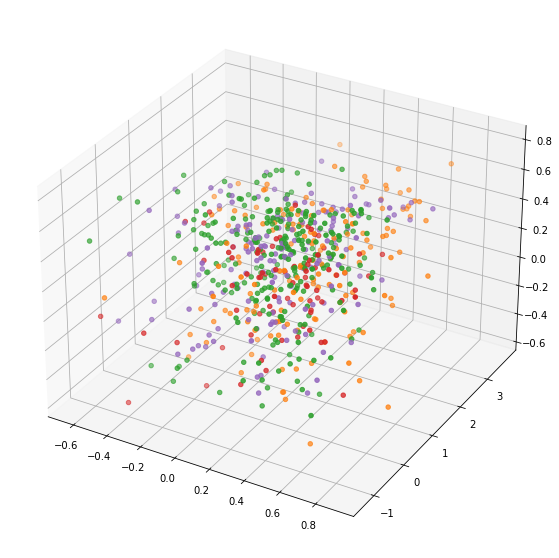

In [420]:
# 3-D plot?
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.scatter3D(cxcl10_shift_corr_drug['pearsonr'],
             cxcl10_shift_corr_drug['ave_CXCL10'],
             cxcl10_shift_corr_drug['ave_shift_ability'],
             c=cxcl10_shift_corr_drug['cluster'])
plt.show()

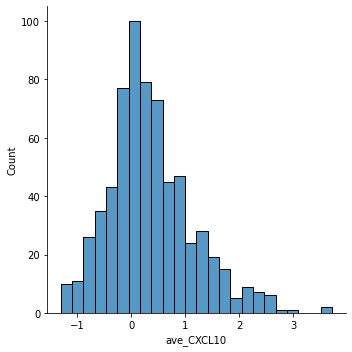

In [425]:
sns.displot(cxcl10_shift_corr_drug['ave_CXCL10'])

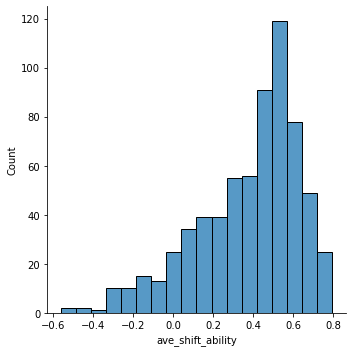

In [426]:
sns.displot(cxcl10_shift_corr_drug['ave_shift_ability'])

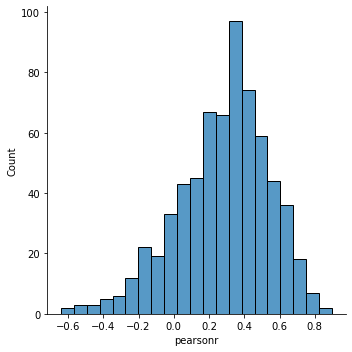

In [427]:
sns.displot(cxcl10_shift_corr_drug['pearsonr'])

In [436]:
# sort by shift-cxcl10 correlation
cxcl10_shift_corr_drug.sort_values(by='pearsonr', ascending=False)

,pearsonr,pearsonp,ave_CXCL10,ave_shift_ability,cmap_name,cluster,#experiment,moa
C1_SNX-2112,0.897648,3.13494e-05,0.122257,-0.327057,SNX-2112,C1,13,Not available
C1_PX-12,0.889584,0.000246009,1.45474,0.301782,PX-12,C1,11,Thioredoxin inhibitor
C2_VU-0410183-2,0.815697,0.00220594,-0.0195947,0.531348,VU-0410183-2,C2,11,Not available
C1_mocetinostat,0.815372,1.18552e-05,0.436219,0.331959,mocetinostat,C1,20,HDAC inhibitor
C3_gemcitabine,0.79101,0.00642978,-0.392664,0.465687,gemcitabine,C3,10,Ribonucleotide reductase inhibitor
...,...,...,...,...,...,...,...,...
C4_CYT-997,-0.513201,0.106421,-0.662617,-0.0998026,CYT-997,C4,11,Tubulin inhibitor
C4_lasalocid,-0.527752,0.116914,-0.197821,0.266544,lasalocid,C4,10,Not available
C3_colchicine,-0.56014,0.0921749,-0.950212,-0.0305126,colchicine,C3,10,Microtubule inhibitor
C2_adarotene,-0.603071,0.00806365,-0.0735503,0.596135,adarotene,C2,18,Retinoid receptor agonist


In [437]:
cxcl10_shift_corr_drug['-log10P'] = -np.log10(cxcl10_shift_corr_drug['pearsonp'].astype(float))

Text(0.5, 1.0, 'CXCL10 vs. shift ability')

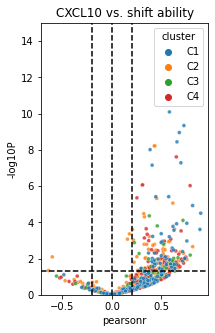

In [440]:
plt.figure(figsize=(3, 5))
sns.scatterplot(x='pearsonr', y='-log10P',
                s=15, alpha=0.8,
                hue='cluster', hue_order=['C1', 'C2', 'C3', 'C4'],
                data=cxcl10_shift_corr_drug)
plt.ylim(0, 15)
plt.axvline(x=0., c='k', ls='--')
plt.axvline(x=0.2, c='k', ls='--')
plt.axvline(x=-0.2, c='k', ls='--')
plt.axhline(y=-np.log10(0.05), c='k', ls='--')
plt.title('CXCL10 vs. shift ability')